## Connectionist Computing - Final Project


Student: Finola Cahill \
Student Number: 07645074

- [Model Definition](#Model-Definition)
- [XOR](#XOR-problem)
- [Sin](#Sin)
- [Letter Recognition](#Letter-Recognition)

In [2169]:
import numpy as np
import pandas as pd
np.random.seed(42)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from sklearn.utils import shuffle
import seaborn

### Model Definition

In [2212]:
class MLP:
    def __init__(self, num_inputs, num_outputs,
                 hidden_units=3, epochs=100, learning_rate=.1,
                 random_state=42, loss='log',
                 first_activation='sig', second_activation='sig',
                 decay=1, verbosity=0, init='he', bias=0.0):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.loss_type = loss
        self.activ_1 = first_activation
        self.activ_2 = second_activation
        self.loss = []
        self.decay = decay
        self.w1 = None
        self.w2 = None
        self.verbosity=verbosity
        self.weight_init = init
        np.random.seed(random_state)
        self.bias_val =float(bias)
    
    def __str__(self):
        return (f"Network with activ1: {self.activ_1}, activ2: {self.activ_2}, lr: {self.learning_rate}, hidden_units: {self.hidden_units}, and loss: {self.loss_type} ")
    
    def __check_parameters(self):
        activations = ['sig', 'tanh', 'softmax', 'relu', 'lin']
        if self.X.shape[0] != self.y.shape[0]:
            raise ValueError('X and Y have mismatched shapes')
        if self.num_inputs < 1:
            raise ValueError('Must have at least 1 input')
        if self.num_outputs < 1:
            raise ValueError('Must have at least 1 output')
        if self.hidden_units < 1:
            raise ValueError('Must have at least 1 hidden unit')
        if self.epochs < 1:
            raise ValueError('Must train for at least 1 epoch')
        if self.learning_rate <=0 or self.learning_rate > 1:
            raise ValueError('Learning rate must be between 0 and 1')
        if self.loss_type not in ['cross', 'mse']:
            raise ValueError('Unknown loss function {}'.format(self.loss_type))
        if self.activ_1 not in activations:
            raise ValueError('Unknown activation function {}'.format(self.a_func_1))
        if self.activ_2 not in activations:
            raise ValueError('Unknown activation function {}'.format(self.a_func_2))

        
    def __set_activation(self, active):
        
        def sigmoid(x, deriv=False):
            if deriv is True:
                return x * (1 - x)
            return (1 / (1 + np.exp(-x)))
        
        def tanh(x, deriv=False):
            if deriv is True:
                return 1 - (x**2)
            return np.tanh(x)
        
        def softmax(x, deriv=False):
            # from https://mlfromscratch.com/neural-network-tutorial/#/
            # for numerical stability, values are normalised
            if deriv is True:
                return np.ones(self.num_outputs)
            tmp = x - x.max(axis=1)[:, np.newaxis]
            np.exp(tmp, out=x)
            return x / x.sum(axis=1)[:, np.newaxis]
        
        def linear(x, deriv=False):
            if deriv is True:
                return 1
            return x  

        def relu(x, deriv=False):
            if deriv is True:
                x[x<=0] = 0
                x[x>0] = 1
                return x
            return np.maximum(x, 0)
        
        activations = {'sig': sigmoid, 'tanh':tanh, 'softmax':softmax,
                 'lin': linear, 'relu':relu}
        
        return activations[active]
    
    def __set_loss_function(self, loss):
        def cross_entropy(deriv=False):
            if deriv is True:
                return (self.output - self.y)
            loss = np.mean(-self.y*(np.nan_to_num(np.log(self.output))))
            if loss == float('inf'):
                print("Loss has exploded for " + self.__str__())
                exit(-1)
            return loss
        
        def mse(deriv=False):
            if deriv == True:
                return -(self.y - self.output)
            loss = 0.5 * (np.sum(np.square(self.y - self.output)))
            if loss == float('inf'):
                print("Loss has exploded for " + self.__str__())
                exit(-1)
            return loss
        if loss == 'cross':
            return cross_entropy
        return mse
        
    def __forward(self):
        self.z1 = self.X@self.w1 + self.b1
        self.a1 = self.__a_func_1(self.z1)
        self.z2 = self.a1@self.w2 + self.b2
        self.output = self.__a_func_2(self.z2)
    
    
    def __backward(self):
        self.loss.append(self.__loss_function())
        d_output = self.__loss_function(deriv=True) * self.__a_func_2(self.output, deriv=True)
        d_w2 = (self.a1.T@d_output)
        d_b2 = (np.sum(d_output, axis = 0, keepdims=True))
        
        d_z1 = (d_output@self.w2.T) * self.__a_func_1(self.a1, deriv=True)
        d_w1 = (self.X.T@d_z1)
        d_b1 = (np.sum(d_z1, axis=0, keepdims=True))
        
        self.__update_weights(d_w1, d_w2, d_b1, d_b2)
    
    def __update_weights(self,d_w1, d_w2, d_b1, d_b2):
        
        #HELLO FINOLA CONSIDER THIS DIVISION RIGHT HERE PLZ THANKYOU
        self.w1 -= ((self.learning_rate * d_w1) / self.num_inputs)
        self.w2 -= ((self.learning_rate * d_w2) / self.num_inputs)
        self.b1 -= ((self.learning_rate * d_b1) / self.num_inputs)
        self.b2 -= ((self.learning_rate * d_b2) / self.num_inputs)

    def __initialise_weights(self, init):
        if init =='xav':
            self.w1 = np.random.randn(self.num_inputs, self.hidden_units) * np.sqrt(1/(self.num_inputs+self.hidden_units))
            self.w2 = np.random.randn(self.hidden_units, self.num_outputs) * np.sqrt(1/(self.hidden_units+self.num_outputs)),
        
        elif init == "zero":
            self.w1 = np.zeros(shape=(self.num_inputs, self.hidden_units))
            self.w2 = np.zeros(shape=(self.hidden_units,self.num_outputs))
        
        elif init == "rand":
            self.w1 = np.random.normal(0, 1, size=(self.num_inputs, self.hidden_units))
            self.w2 = np.random.normal(0, 1, size=(self.hidden_units, self.num_outputs))
        
        else: #he initialization
            self.w1 = np.random.randn(self.num_inputs, self.hidden_units)*np.sqrt(2/self.num_inputs)
            self.w2 = np.random.randn(self.hidden_units, self.num_outputs)*np.sqrt(2/self.hidden_units)
                                   
        self.b1 = np.full(shape=(1,self.hidden_units), fill_value=self.bias_val)
        self.b2 = np.full(shape=(1,self.num_outputs), fill_value=self.bias_val)
    
    def fit(self, x, y):
        self.X = x
        self.y = y
        self.__check_parameters()
        self.__loss_function = self.__set_loss_function(self.loss_type)
        self.__a_func_1 = self.__set_activation(self.activ_1)
        self.__a_func_2 = self.__set_activation(self.activ_2)
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.__initialise_weights(self.weight_init)

        
        for i in range (self.epochs):
#             if i == 1000:
#                 self.learning_rate /= 10
#             if i == 4000:
#                 self.learning_rate *= 5
#             if i == 6000:
#                 self.learning_rate /= 5
#             if i == 7500:
#                 self.learning_rate *= 10
#             if i == 9000:
#                 self.learning_rate /= 10
#             if i == 15000:
#                 self.learning_rate *= 2
#             if i == 20000:
#                 self.learning_rate /= 8
#             if i == 21000:
#                 self.learning_rate = 0.0001
            self.X, self.y = shuffle(x, y)
            self.__forward()
            self.__backward()
            if self.verbosity > 0:
                print("Epoch {} LR {} Loss is {}".format(i+1, self.learning_rate, self.loss[-1]))
        return self
    
    def predict(self, x):
        if self.w1 is None or self.w2 is None:
            raise ValueError("Weights have not been initialised. Model is not fit")
        if x.shape[1] != self.num_inputs:
            raise ValueError("Shape mismatch, this model expects {} inputs".format(self.num_inputs))
        self.X = x
        self.__forward()
        return self.output

### TEST ERROR CHECKING

### XOR 

##### Initialising and exploring the data

In [2055]:
# Initialising input and targets

x =np.vstack(([0,0],[0,1],[1,0],[1,1]))
y =np.array([0,1,1,0]).reshape(-1,1)
x.shape[1],y.shape[1]

(2, 1)

Text(0.5, 1.0, 'XOR Gate')

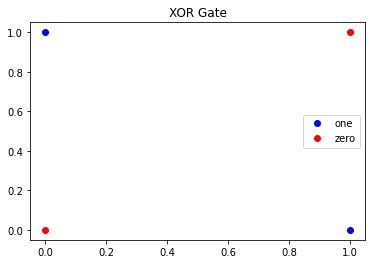

In [2072]:
# Plotting the XOR problem

plt.plot(0,1, 'bo', label="one")
plt.plot(1,0, 'bo')
plt.plot(0,0, 'ro', label="zero")
plt.plot(1,1, 'ro')
plt.legend()
plt.title("XOR Gate")


##### Initial test of the network

In [2163]:
ep = 10000
lr = .1
hid = 4
init = 'he'
mlp_1 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_2 = MLP(x.shape[1],y.shape[1],hid, init=init,first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_3 = MLP(x.shape[1],y.shape[1],hid, init=init,first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_4 = MLP(x.shape[1],y.shape[1],hid, init=init,first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)


In [2164]:
XOR_results = pd.DataFrame(columns = ["T1", "T2","T3", "T4"], index=['Target','Sigmoid', 'Tanh', 'Relu','Linear'])
XOR_results.loc['Target'] = [0,1,1,0]


In [2165]:
XOR_results.loc['Sigmoid'] = (mlp_1.fit(x,y).predict(x)).tolist()
XOR_results.loc['Tanh'] = (mlp_2.fit(x,y).predict(x)).tolist()
XOR_results.loc['Relu'] = (mlp_3.fit(x,y).predict(x)).tolist()
XOR_results.loc['Linear'] = (mlp_4.fit(x,y).predict(x)).tolist()


In [2162]:
XOR_results

,T1,T2,T3,T4
Target,0,1,1,0
Sigmoid,[0.12411513951158369],[0.4808365004111237],[0.891432105087023],[0.5079595004208167]
Tanh,[0.0006913491611939449],[0.4998606541166031],[0.9753227088372329],[0.5021731150195978]
Relu,[0.0],[0.0],[0.0],[0.0]
Linear,[0.5000000000000004],[0.5000000000000001],[0.5000000000000003],[0.5]


Text(0.5, 1.0, 'Loss over 10,000 Epochs')

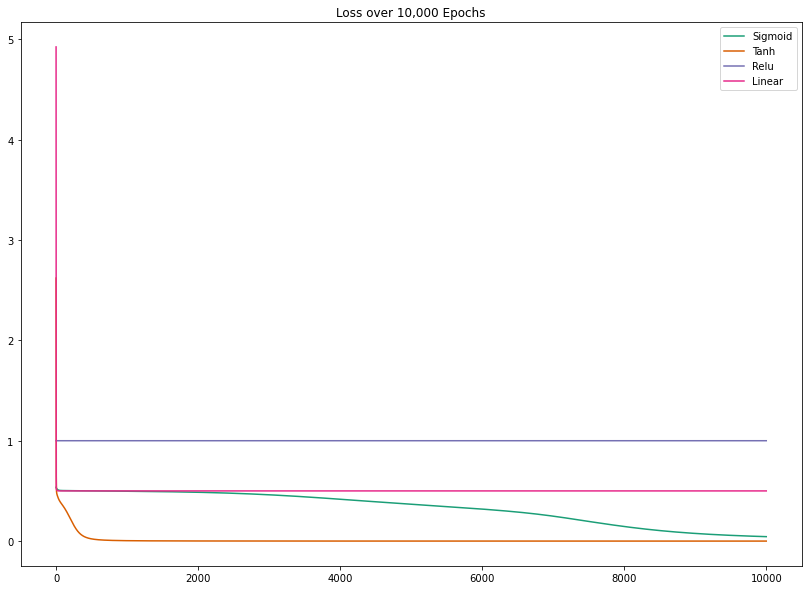

In [2141]:
plt.figure(figsize=(14, 10))
plt.plot(mlp_1.loss, label='Sigmoid')
plt.plot(mlp_2.loss, label='Tanh')
plt.plot(mlp_3.loss, label='Relu')
plt.plot(mlp_4.loss, label='Linear')
plt.legend()
plt.title("Loss over 10,000 Epochs")

##### Testing effect of number of hidden units

In [2142]:
epochs = 10000
lr = .1
init = 'he'
sig_hid, tan_hid, relu_hid, lin_hid = [],[],[],[]
for hid in range(1, 13):
    mlp_1 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_2 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_3 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_4 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    sig_hid.append(mlp_1.fit(x,y).loss)
    tan_hid.append(mlp_2.fit(x,y).loss)
    relu_hid.append(mlp_3.fit(x,y).loss)
    lin_hid.append(mlp_4.fit(x,y).loss)

Text(0.5, 0.98, 'Effect of Varying Hidden Units -- XOR')

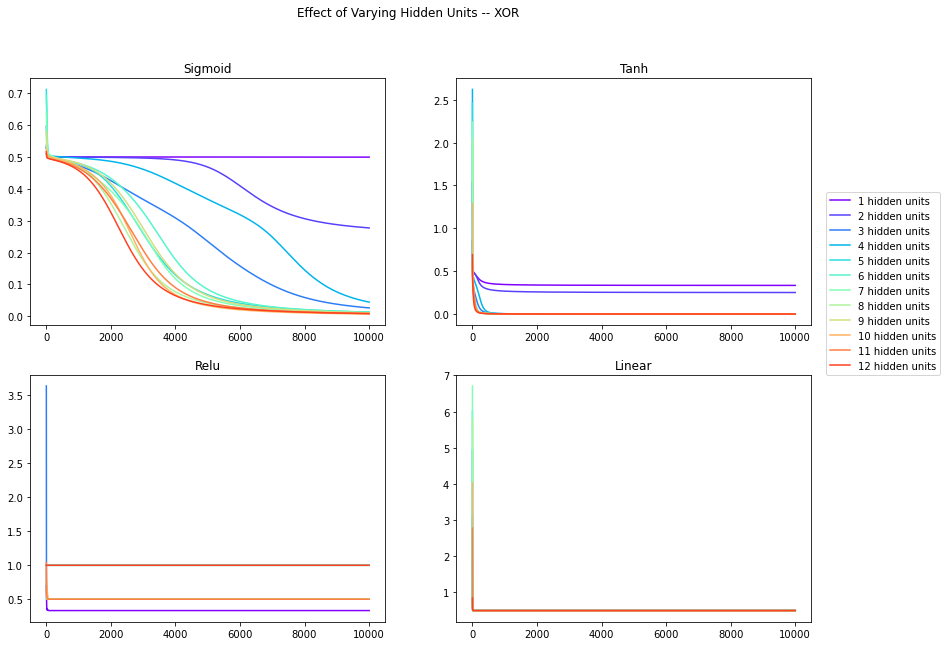

In [2143]:
fig, axs = plt.subplots(2,2)
color=iter(cm.rainbow(np.linspace(0,1,13)))
fig.set_figheight(10)
fig.set_figwidth(14)
for i in range(0, 12):
    c=next(color)
    axs[0][0].plot(sig_hid[i], label=str(i+1)+" hidden units", c=c)
    axs[0][0].set_title("Sigmoid")
    axs[0][1].plot(tan_hid[i], label=str(i+1)+" hidden units", c=c)
    axs[0][1].set_title("Tanh")
    axs[1][0].plot(relu_hid[i], label=str(i+1)+" hidden units", c=c)
    axs[1][0].set_title("Relu")
    axs[1][1].plot(lin_hid[i], label=str(i+1)+" hidden units", c=c)
    axs[1][1].set_title("Linear")
axs[1][0].legend(loc=(2.24,1))
fig.suptitle("Effect of Varying Hidden Units -- XOR")

##### Testing effect of number of varying learning rate


In [2166]:
learning_rate = [1, .5 ,.1,.05,.01,.005,.001,.0005,.0001]
epochs = 10000
hid = 2
init='he'
sig_lr, tan_lr, relu_lr, lin_lr = [],[],[],[]
for lr in learning_rate:
    print('..............')
    print("Learning rate: ",lr)
    print("\t Training sig")
    mlp_1 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    print("\t Training tanh")
    mlp_2 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    print("\t Training ReLU")
    mlp_3 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    print("\t Training Linear")
    mlp_4 = MLP(x.shape[1],y.shape[1],hid, init=init, first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    sig_lr.append(mlp_1.fit(x,y).loss)
    tan_lr.append(mlp_2.fit(x,y).loss)
    relu_lr.append(mlp_3.fit(x,y).loss)
    lin_lr.append(mlp_4.fit(x,y).loss)


..............
Learning rate:  1
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear


<ipython-input-2158-5620cf10c70e>:101: RuntimeWarning: overflow encountered in square
  loss = 0.5 * (np.sum(np.square(self.y - self.output)))
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-2158-5620cf10c70e>:113: RuntimeWarning: overflow encountered in matmul
  self.z2 = self.a1@self.w2 + self.b2
<ipython-input-2158-5620cf10c70e>:120: RuntimeWarning: invalid value encountered in matmul
  d_w2 = (self.a1.T@d_output)
<ipython-input-2158-5620cf10c70e>:124: RuntimeWarning: invalid value encountered in matmul
  d_w1 = (self.X.T@d_z1)
<ipython-input-2158-5620cf10c70e>:134: RuntimeWarning: invalid value encountered in subtract
  self.b1 -= ((self.learning_rate * d_b1) / self.num_inputs)


Loss has exploded for Network with activ1: lin, activ2: lin, lr: 1, hidden_units: 2, and loss: mse 
Loss has exploded for Network with activ1: lin, activ2: lin, lr: 1, hidden_units: 2, and loss: mse 
..............
Learning rate:  0.5
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear
..............
Learning rate:  0.1
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear
..............
Learning rate:  0.05
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear
..............
Learning rate:  0.01
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear
..............
Learning rate:  0.005
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear
..............
Learning rate:  0.001
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear
..............
Learning rate:  0.0005
	 Training sig
	 Training tanh
	 Training ReLU
	 Training Linear
..............
Learning rate:  0.0001
	 Training sig
	 Training tanh
	 Training ReLU
	 Trai

Text(0.5, 0.98, 'Effect of Varying LR -- XOR')

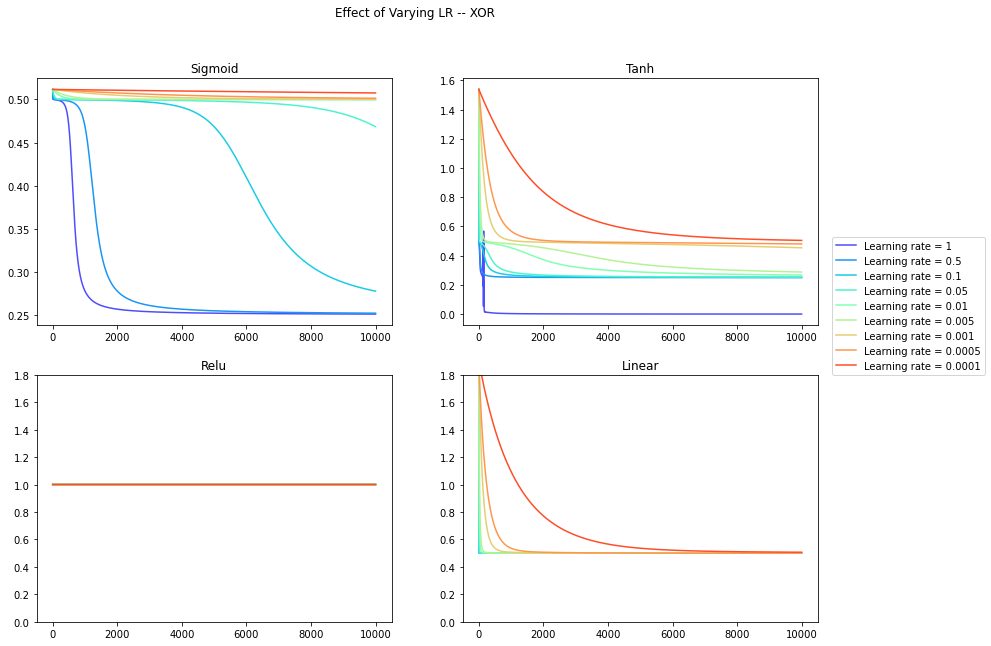

In [2168]:
fig, axs = plt.subplots(2,2)
color=iter(cm.rainbow(np.linspace(0,1,11)))
c=next(color)
fig.set_figheight(10)
fig.set_figwidth(14)
for i, lr in enumerate(learning_rate):
    c=next(color)
    axs[0][1].set_title("Tanh")
    axs[0][0].plot(sig_lr[i], label="Learning rate = " + str(lr), c=c)
    axs[0][0].set_title("Sigmoid")
    axs[0][1].plot(tan_lr[i], label="Learning rate = " + str(lr), c=c)
    axs[0][1].set_title("Tanh")
    axs[1][0].plot(relu_lr[i], label="Learning rate = " + str(lr), c=c)
    axs[1][0].set_title("Relu")
    axs[1][0].set_ylim(0,1.8)
    axs[1][1].plot(lin_lr[i], label="Learning rate = " + str(lr), c=c)
    axs[1][1].set_title("Linear")
    axs[1][1].set_ylim(0,1.8)
axs[1][0].legend(loc=(2.24,1))
fig.suptitle("Effect of Varying LR -- XOR")

##### Effect of varying initialization

In [2149]:
epochs = 10000
lr = .1
hid = 4
init = ['xav', 'zero', 'rand', 'he']
sig_in, tan_in, rel_in, lin_in = [],[],[],[]
for ini in init:
    mlp_1 = MLP(x.shape[1],y.shape[1],hid, init=ini, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_2 = MLP(x.shape[1],y.shape[1],hid, init=ini, first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_3 = MLP(x.shape[1],y.shape[1],hid, init=ini, first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_4 = MLP(x.shape[1],y.shape[1],hid, init=ini, first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    sig_in.append(mlp_1.fit(x,y).loss)
    tan_in.append(mlp_2.fit(x,y).loss)
    rel_in.append(mlp_3.fit(x,y).loss)
    lin_in.append(mlp_4.fit(x,y).loss)

Text(0.5, 0.98, 'Effects of initialisation on Loss')

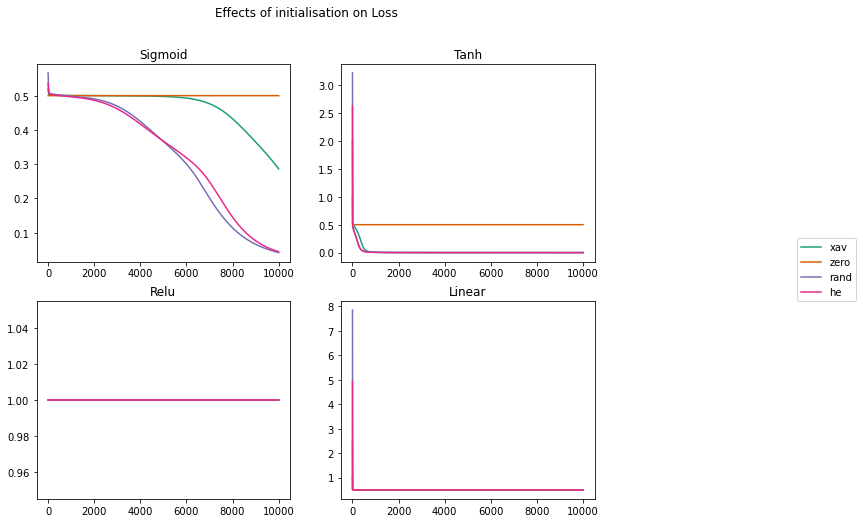

In [2155]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)
for i, ini in enumerate(init):
    axs[0][0].plot(sig_in[i], label=ini)
    axs[0][0].set_title("Sigmoid")
    axs[0][1].plot(tan_in[i], label=ini)
    axs[0][1].set_title("Tanh")
    axs[1][0].plot(rel_in[i], label=ini)
    axs[1][0].set_title("Relu")
    axs[1][1].plot(lin_in[i], label=ini)
    axs[1][1].set_title("Linear")
axs[1][0].legend(loc=(3, 1))
fig.suptitle("Effects of initialisation on Loss")

##### Effect of varying bias initialization

In [2156]:
epochs = 10000
lr = .1
hid = 4
ini = 'he'
biases = [-.1, 0, 0.1, 0.5, 1]
sig_b, tan_b, rel_b, lin_b = [],[],[],[]
for b in biases:
    mlp_1 = MLP(x.shape[1],y.shape[1],hid, init=ini, bias=b, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_2 = MLP(x.shape[1],y.shape[1],hid, init=ini, bias=b, first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_3 = MLP(x.shape[1],y.shape[1],hid, init=ini, bias=b, first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_4 = MLP(x.shape[1],y.shape[1],hid, init=ini, bias=b, first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    sig_b.append(mlp_1.fit(x,y).loss)
    tan_b.append(mlp_2.fit(x,y).loss)
    rel_b.append(mlp_3.fit(x,y).loss)
    lin_b.append(mlp_4.fit(x,y).loss)

Text(0.5, 0.98, 'Effects of initialisation on Loss')

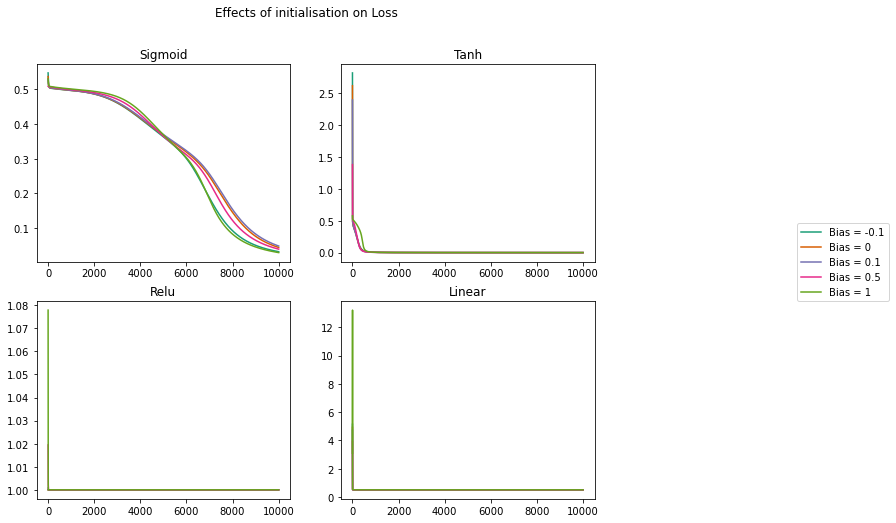

In [2157]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)
for i, b in enumerate(biases):
    axs[0][0].plot(sig_b[i], label="Bias = " + str(b))
    axs[0][0].set_title("Sigmoid")
    axs[0][1].plot(tan_b[i], label="Bias = " + str(b))
    axs[0][1].set_title("Tanh")
    axs[1][0].plot(rel_b[i], label="Bias = " + str(b))
    axs[1][0].set_title("Relu")
    axs[1][1].plot(lin_b[i], label="Bias = " + str(b))
    axs[1][1].set_title("Linear")
axs[1][0].legend(loc=(3, 1))
fig.suptitle("Effects of initialisation on Loss")

### Sin

In [1495]:
def SSE(y_pred, y_true):
    return np.sum((y_true-y_pred)**2)

In [2016]:
data = []
y_data = []
for n in range(100):
    data.append(np.random.uniform(low=-1.0,high=1.0, size=(4, 1)))
    y_data.append(np.sin(data[-1][0] - data[-1][1] + data[-1][2] - data[-1][3]))
y_data = np.array(y_data)
X_data = np.array(data)
X_data = X_data.reshape(100, 4)

In [2017]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.25, train_size = 0.75)

In [2018]:
print(np.max(y_data))
print(np.min(y_data))

0.9991531599454687
-0.9985313839473915


In [1523]:
ep = 10000
lr = .01
hid = 2
mlp_1 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_2 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_3 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
mlp_4 = MLP(X_train.shape[1],y_train.shape[1],hid, first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)


In [1524]:
sig_train = mlp_1.fit(X_train,y_train).predict(X_train)
tan_train = mlp_2.fit(X_train,y_train).predict(X_train)
rel_train = mlp_3.fit(X_train,y_train).predict(X_train)
lin_train = mlp_4.fit(X_train,y_train).predict(X_train)

In [1525]:
sig_test = mlp_1.predict(X_test)
tan_test = mlp_2.predict(X_test)
rel_test = mlp_3.predict(X_test)
lin_test = mlp_4.predict(X_test)

In [1527]:
XOR_results['Sigmoid'] = [SSE(sig_train, y_train), SSE(sig_test, y_test)]
XOR_results['Tanh'] = [SSE(tan_train, y_train), SSE(tan_test, y_test)]
XOR_results['Relu'] = [SSE(rel_train, y_train), SSE(rel_test, y_test)]
XOR_results['Linear'] = [SSE(lin_train, y_train), SSE(lin_test, y_test)]

In [1528]:
XOR_results

,Sigmoid,Tanh,Linear,Relu
test,15.156565,0.826668,5.388366,14.454742
train,4.088066,0.136287,1.708202,4.058132


Text(0.5, 0.98, 'Prediction Accuracy for Test Set')

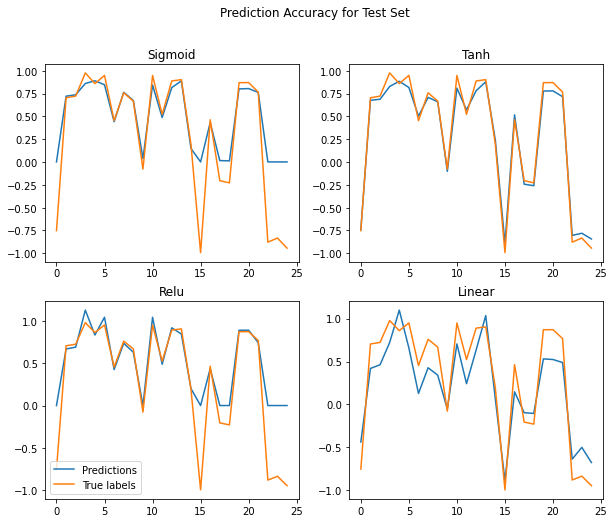

In [1559]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)
axs[0][0].plot(sig_test, label="Predictions")
axs[0][0].plot(y_test, label="True labels")
axs[0][0].set_title("Sigmoid")
axs[0][1].plot(tan_test, label="Predictions")
axs[0][1].plot(y_test, label="True labels")
axs[0][1].set_title("Tanh")
axs[1][0].plot(rel_test, label="Predictions")
axs[1][0].plot(y_test, label="True labels")
axs[1][0].set_title("Relu")
axs[1][1].plot(lin_test, label="Predictions")
axs[1][1].plot(y_test, label="True labels")
axs[1][1].set_title("Linear")
axs[1][0].legend()
fig.suptitle("Prediction Accuracy for Test Set")

In [59]:
def SSE(predict, y):
    return np.power((predict - y), 2).mean()

In [60]:
test_epochs = [1000, 10000, 100000, 1000000]

In [104]:
model = 1
for epoch in test_epochs:
    for hidden in range(2, 6):
        print('testing model {}'.format(model))
        test = MLP(X_train,y_train,hidden,random_state=0, epochs=epoch)
        test.fit(X_train, y_train)
        train_error = SSE(test.predict(X_train), y_train)
        test_error = SSE(test.predict(X_test), y_test)
        results6[model] = [epoch, hidden, train_error, test_error]
        model += 1

testing model 1
testing model 2
testing model 3
testing model 4
testing model 5
testing model 6
testing model 7
testing model 8
testing model 9
testing model 10
testing model 11
testing model 12
testing model 13
testing model 14
testing model 15
testing model 16


In [2060]:
ep = 10000
lr = .01
hid = 5
init = ['xav', 'zero', 'rand', 'he']
sig_in, tan_in, rel_in, lin_in = [],[],[],[]
for ini in init:
    mlp_1 = MLP(X_train.shape[1],y_train.shape[1],hid, init=ini, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_2 = MLP(X_train.shape[1],y_train.shape[1],hid, init=ini,first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_3 = MLP(X_train.shape[1],y_train.shape[1],hid, init=ini,first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_4 = MLP(X_train.shape[1],y_train.shape[1],hid, init=ini,first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    sig_in.append(mlp_1.fit(X_train, y_train).predict(X_test))
    tan_in.append(mlp_2.fit(X_train, y_train).predict(X_test))
    rel_in.append(mlp_3.fit(X_train, y_train).predict(X_test))
    lin_in.append(mlp_4.fit(X_train, y_train).predict(X_test))

 

xav
xav
xav
xav
zero
zero
zero
zero
rand
rand
rand
rand
he
he
he
he


Text(0.5, 0.98, 'Effects of initialisation on accuracy')

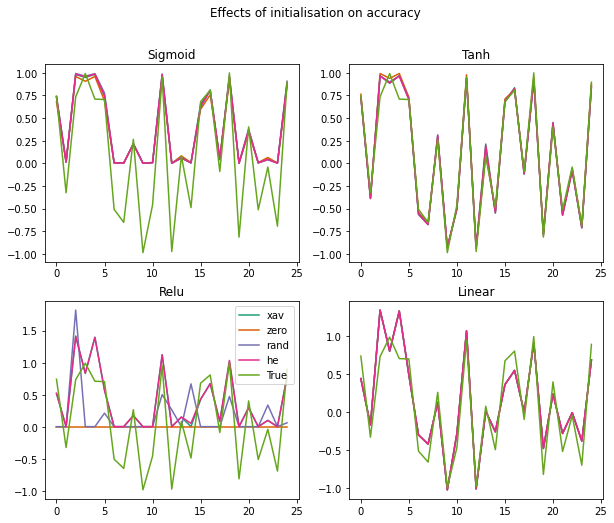

In [2070]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)
for i, ini in enumerate(init):
    axs[0][0].plot(sig_in[i], label=ini)
    axs[0][0].set_title("Sigmoid")
    axs[0][1].plot(tan_in[i], label=ini)
    axs[0][1].set_title("Tanh")
    axs[1][0].plot(rel_in[i], label=ini)
    axs[1][0].set_title("Relu")
    axs[1][1].plot(lin_in[i], label=ini)
    axs[1][1].set_title("Linear")
axs[0][0].plot(y_test, label="True")
axs[0][1].plot(y_test, label="True")
axs[1][0].plot(y_test, label="True")
axs[1][1].plot(y_test, label="True")
axs[1][0].legend()
fig.suptitle("Effects of initialisation on accuracy")

In [2067]:
ep = 10000
lr = .01
hid = 5
b = 1.0
init = ['xav', 'zero', 'rand', 'he']
sig_in, tan_in, rel_in, lin_in = [],[],[],[]
for ini in init:
    mlp_1 = MLP(X_train.shape[1],y_train.shape[1],hid, bias=b, init=ini, first_activation='sig', second_activation='sig',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_2 = MLP(X_train.shape[1],y_train.shape[1],hid, bias=b, init=ini,first_activation='tanh', second_activation='tanh',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_3 = MLP(X_train.shape[1],y_train.shape[1],hid, bias=b, init=ini,first_activation='relu', second_activation='relu',epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    mlp_4 = MLP(X_train.shape[1],y_train.shape[1],hid, bias=b,init=ini,first_activation='lin', second_activation='lin', epochs=ep, learning_rate=lr, loss='mse', verbosity=0)
    sig_in.append(mlp_1.fit(X_train, y_train).predict(X_test))
    tan_in.append(mlp_2.fit(X_train, y_train).predict(X_test))
    rel_in.append(mlp_3.fit(X_train, y_train).predict(X_test))
    lin_in.append(mlp_4.fit(X_train, y_train).predict(X_test))

 

xav
xav
xav
xav
zero
zero
zero
zero
rand
rand
rand
rand
he
he
he
he


Text(0.5, 0.98, 'Effects of initialisation on accuracy')

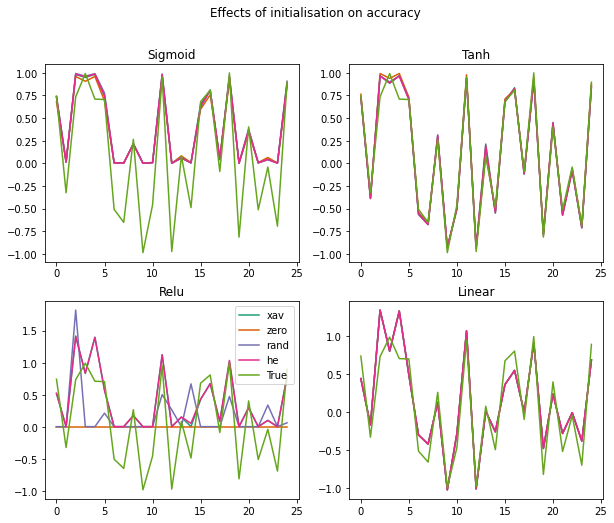

In [2069]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)
for i, ini in enumerate(init):
    axs[0][0].plot(sig_in[i], label=ini)
    axs[0][0].set_title("Sigmoid")
    axs[0][1].plot(tan_in[i], label=ini)
    axs[0][1].set_title("Tanh")
    axs[1][0].plot(rel_in[i], label=ini)
    axs[1][0].set_title("Relu")
    axs[1][1].plot(lin_in[i], label=ini)
    axs[1][1].set_title("Linear")
axs[0][0].plot(y_test, label="True")
axs[0][1].plot(y_test, label="True")
axs[1][0].plot(y_test, label="True")
axs[1][1].plot(y_test, label="True")
axs[1][0].legend()
fig.suptitle("Effects of initialisation on accuracy")

### Letter Recognition

##### Load and normalise data

In [2182]:
X_data = pd.read_csv('letter-recognition.data', sep=",")

In [2183]:
y_data = np.array(X_data.pop(X_data.columns[0]))
X_data = np.array(X_data, dtype='float64')

In [2184]:
y_data = y_data.astype(dtype='<U1')

<AxesSubplot:ylabel='count'>

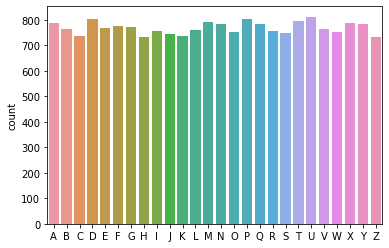

In [2185]:
unique, counts = np.unique(y_data, return_counts=True)
values = dict(zip(unique, counts/len(y_data) * 100))
seaborn.countplot(x=sorted(y_data))

In [2186]:
print("Standard deviation of letter proportion: ", np.std(list(values.values())))

Standard deviation of letter proportion:  0.11340607756445167


The dataset is relatively balanced

In [2187]:
print(X_data.shape, y_data.shape)

(19999, 16) (19999,)


In [2188]:
# Converting letter data to ints
y_data = np.array(y_data.view(np.uint32)) - 65

In [2189]:
#Uncomment to return numbers to letters
#np.char.mod('%c', y_data+65)

In [2190]:
# Splitting the data with a 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.25, train_size = 0.75)

In [2191]:
# Converting the targets to a wide representation for use with softmax
y_train_wide = to_categorical(y_train)
y_test_wide = to_categorical(y_test)

In [2192]:
# Normalising the data
X_data /= np.max(X_data)

In [2213]:
# # New learning rate decay formula, starting with higher lr
# hid = 10
# epochs = 2000
# lr = 0.01
# activations = ['sig', 'tanh', 'relu', 'lin']
# loss, train, test = [],[],[]
# for a in activations:
#     mlp = MLP(X_train.shape[1], y_train_wide.shape[1],hidden_units=hid,
#             epochs=epochs, learning_rate=lr, loss='cross', 
#             first_activation = a, second_activation='softmax', verbosity=0)
#     mlp.fit(X_train, y_train_wide)
#     train_pred_wide = mlp.predict(X_train)
#     test_pred_wide = mlp.predict(X_test)
#     train.append(np.argmax(train_pred_wide, axis=1))
#     test.append(np.argmax(test_pred_wide, axis=1))
#     loss.append(mlp.loss)

In [2208]:
for i, a in enumerate(activations):
    print(a + ": train accuracy= {} test accuracy={}".format((train[i]==y_train).sum()/y_train.shape[0],
                                                             (test[i]==y_test).sum()/y_test.shape[0]))

sig: train accuracy= 0.041269417961197416 test accuracy=0.0388
tanh: train accuracy= 0.040602706847123145 test accuracy=0.0388
relu: train accuracy= 0.041269417961197416 test accuracy=0.0388
lin: train accuracy= 0.038802586839122605 test accuracy=0.0414


In [2215]:
# New learning rate decay formula, starting with higher lr
hidden = [26]
prev = results8
results8 = []
loss = []
for h in hidden:
    mlp = MLP(X_train.shape[1], y_train_wide.shape[1],
            hidden_units=h,
            epochs=5000,
            learning_rate=0.001, loss='cross', init='he',
            first_activation = 'sig', second_activation='softmax', decay=1, verbosity=1)
    mlp.fit(X_train, y_train_wide)
#     save_iter(mlp.loss, "mill_loss_"+str(h))
#     save_iter(mlp.w1, "mill_weight_1_"+str(h))
#     save_iter(mlp.w2, "mill_weight_2_"+str(h))
    train_pred_wide = mlp.predict(X_train)
    test_pred_wide = mlp.predict(X_test)
    train_pred = np.argmax(train_pred_wide, axis=1)
    test_pred = np.argmax(test_pred_wide, axis=1)
    res = "h = {}, train acc = {} test acc = {}".format(h, ((train_pred == y_train).sum()/y_train.shape[0] * 100), ((test_pred == y_test).sum()/y_test.shape[0]) * 100)
    results8.append(res)
    loss.append(mlp.loss)

Epoch 1 LR 0.001 Loss is 0.14584066965463158
Epoch 2 LR 0.001 Loss is 0.12845297181874474
Epoch 3 LR 0.001 Loss is 0.12378940204022133
Epoch 4 LR 0.001 Loss is 0.1218765150647566
Epoch 5 LR 0.001 Loss is 0.1206625809270525
Epoch 6 LR 0.001 Loss is 0.11938806209182984
Epoch 7 LR 0.001 Loss is 0.11848050742727567
Epoch 8 LR 0.001 Loss is 0.11748141834837457
Epoch 9 LR 0.001 Loss is 0.11684505141047494
Epoch 10 LR 0.001 Loss is 0.11566263353553331
Epoch 11 LR 0.001 Loss is 0.11525585003674609
Epoch 12 LR 0.001 Loss is 0.11541103818897422
Epoch 13 LR 0.001 Loss is 0.11558312794353755
Epoch 14 LR 0.001 Loss is 0.11602762494379378
Epoch 15 LR 0.001 Loss is 0.11464173197529019
Epoch 16 LR 0.001 Loss is 0.11354191736596793
Epoch 17 LR 0.001 Loss is 0.11243900481932792
Epoch 18 LR 0.001 Loss is 0.11252057368219942
Epoch 19 LR 0.001 Loss is 0.11178528149445419
Epoch 20 LR 0.001 Loss is 0.11102193713977854
Epoch 21 LR 0.001 Loss is 0.11064189665778199
Epoch 22 LR 0.001 Loss is 0.10944991466829863

Epoch 189 LR 0.001 Loss is 0.06016731983514964
Epoch 190 LR 0.001 Loss is 0.06059401024164833
Epoch 191 LR 0.001 Loss is 0.05998354719035987
Epoch 192 LR 0.001 Loss is 0.06009944154390067
Epoch 193 LR 0.001 Loss is 0.05997830980366762
Epoch 194 LR 0.001 Loss is 0.06056329841593012
Epoch 195 LR 0.001 Loss is 0.05979907847015809
Epoch 196 LR 0.001 Loss is 0.059368162181925595
Epoch 197 LR 0.001 Loss is 0.05924848986363503
Epoch 198 LR 0.001 Loss is 0.05964355508185001
Epoch 199 LR 0.001 Loss is 0.059115607962984304
Epoch 200 LR 0.001 Loss is 0.05884677603706902
Epoch 201 LR 0.001 Loss is 0.05917607660996814
Epoch 202 LR 0.001 Loss is 0.059612645317138134
Epoch 203 LR 0.001 Loss is 0.05873629443976059
Epoch 204 LR 0.001 Loss is 0.0583113663652751
Epoch 205 LR 0.001 Loss is 0.05846328673166749
Epoch 206 LR 0.001 Loss is 0.05889705280645367
Epoch 207 LR 0.001 Loss is 0.057957750589645765
Epoch 208 LR 0.001 Loss is 0.05811875306087621
Epoch 209 LR 0.001 Loss is 0.05807373971114425
Epoch 210 

KeyboardInterrupt: 

In [2195]:
print("prev", prev)
for r in results8:
    print(r)

sig: train accuracy= 0.041269417961197416 test accuracy=0.0388
tanh: train accuracy= 0.040602706847123145 test accuracy=0.0388
relu: train accuracy= 0.041269417961197416 test accuracy=0.0388
lin: train accuracy= 0.038802586839122605 test accuracy=0.0414


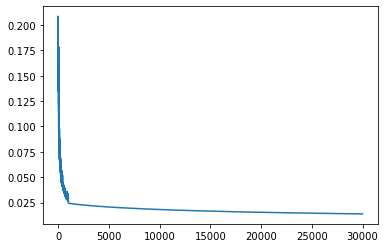

In [1276]:
for l in loss:
    plt.plot(l, label=l)
#plt.legend()


In [112]:
train_pred_wide = mlp.predict(X_train)
test_pred_wide = mlp.predict(X_test)
train_pred = np.argmax(train_pred_wide, axis=1)
test_pred = np.argmax(test_pred_wide, axis=1)
print("train acc", (train_pred == y_train).sum()/y_train.shape[0] * 100)
print("test acc", ((test_pred == y_test).sum()/y_test.shape[0]) * 100)

train acc 42.729515301020065
test acc 42.46


In [365]:
def save_iter(thing, path):
    textfile = open(path, "w")
    for element in thing:
        textfile.write(str(element) + "\n")
    textfile.close()